In [33]:
# Set directory to store-sales-time-series-forecasting
import os
import gc
import pandas as pd
import numpy as np


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import plotly.express as px


import seaborn as sns

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#os.chdir('./store-sales-time-series-forecasting')


In [82]:
import statsmodels
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import plotly.graph_objs as go


In [79]:
#import train and test data
train = pd.read_csv('train.csv', index_col=['date'], parse_dates=['date'])
test = pd.read_csv('test.csv')

#import stores data
stores = pd.read_csv('stores.csv')

#import holidays data
holidays = pd.read_csv('holidays_events.csv', index_col=['date'], parse_dates=['date'])

#import oil data
oil = pd.read_csv('oil.csv')

#import transactions data
transactions = pd.read_csv('transactions.csv', index_col=['date'], parse_dates=['date'])

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [28]:
# Group by date and sum the sales
train_date = train.groupby('date')['sales'].sum().reset_index()


In [29]:
train_date.head()

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


The outliers are the 1st of January where many stores are perhaps closed. Impute the missing values?


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


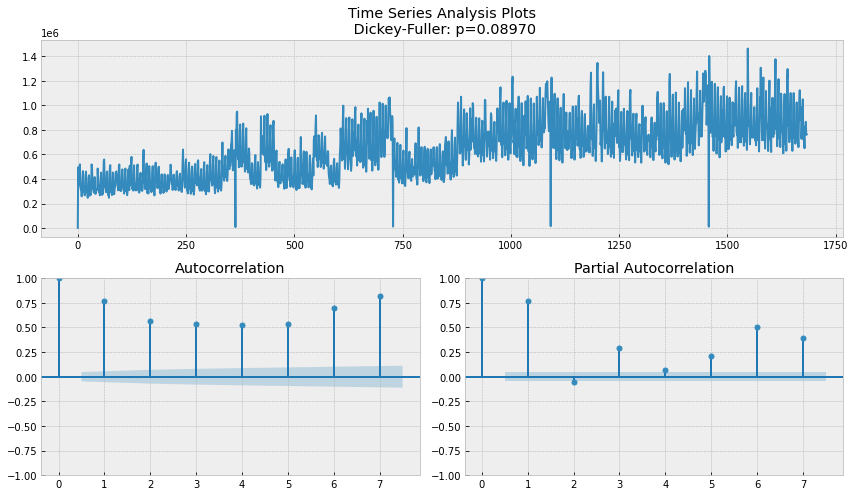

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


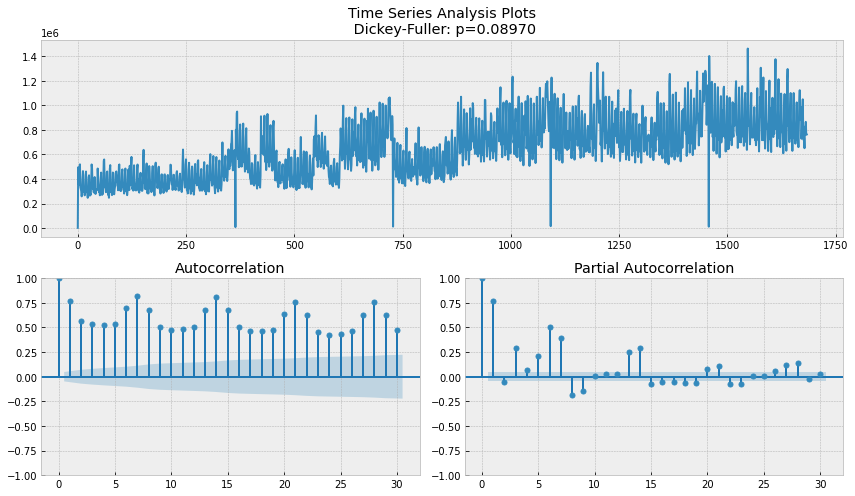

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


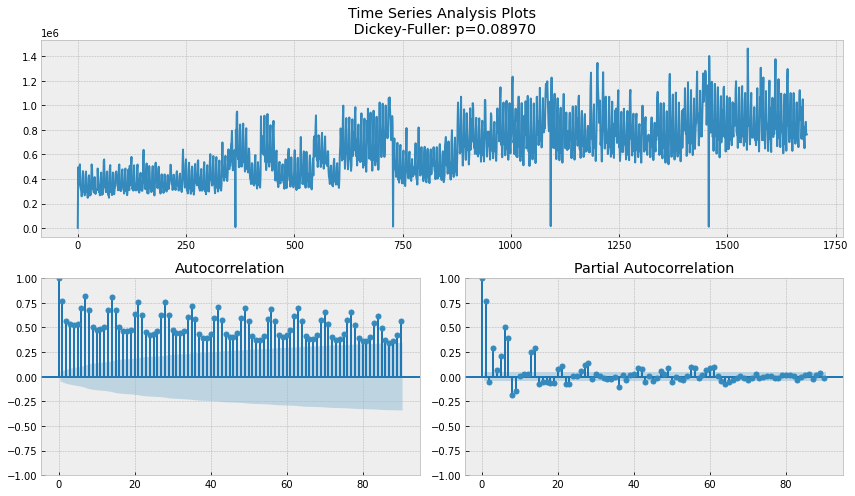

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


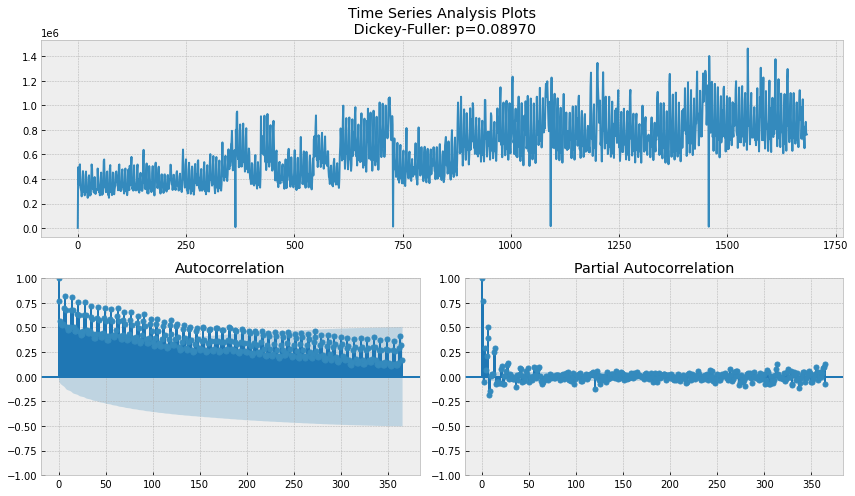

In [32]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
   

for i in [7, 30, 90, 365]:
    tsplot(train_date.sales, lags=i)
    plt.show()

In [121]:
train_aux = train[['sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()

fig = px.scatter(train_aux[train_aux['onpromotion'] > 0], x="onpromotion", y="sales", color='sales', 
                           color_continuous_scale="earth",
                 size='sales', log_x=True, size_max=30)

fig.update_layout({"title": f'Correlation between OnPromotion and Sales (total avg sales and promotion on each day)',
                   "xaxis": {"title":"On Promotion"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})

In [85]:
# in train, find the correlation between different family
train_family = train[['family', 'sales']].groupby('family').mean()
train_family = train_family.reset_index()
fig = px.bar(train_family, x='family', y='sales', color='sales', color_continuous_scale="earth")
fig.update_layout({"title": f'Avg Sales by family for all stores and products',
                     "xaxis": {"title":"Family"},
                        "yaxis": {"title":"Avg Unit Sold"},
                        "showlegend": False})
fig.show()


In [88]:
# Visualise the price of oil over time

fig = px.line(oil, x='date', y='dcoilwtico', title='Oil Price over time')

fig.show()

In [122]:
# Get datatype of data in oil
# Change oil to a datetime64[ns]
oil['date'] = pd.to_datetime(oil['date'])
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [123]:
#Scatter plot to the see correlation between average unit sold and oil price each day 
sales_oil = train.groupby('date').mean()['sales']
sales_oil = sales_oil.reset_index()
sales_oil = pd.merge(sales_oil, oil, on ='date', how='left')
# we don't have all the oil prices available, we impute them 
sales_oil = sales_oil.interpolate(method='bfill', limit=20)

fig = px.scatter(sales_oil, x="dcoilwtico", y="sales", size='sales', color='sales',
                  color_continuous_scale="pinkyl")

fig.update_layout({"title": f'Correlation between Oil Prices and Sales (total avg sales and promotion each day)',
                   "xaxis": {"title":"Oil Price"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})



fig.show()

In [126]:
# plot oil price and sales on the same graph, scaling both such that they are on the same scale
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_oil['date'], y=sales_oil['sales']/sales_oil['sales'].max(), name='Sales',
                            line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=sales_oil['date'], y=sales_oil['dcoilwtico']/sales_oil['dcoilwtico'].max(), name='Oil Price',
                            line=dict(color='royalblue', width=2)))

fig.update_layout(title_text='Oil Price and Sales over time (Normalised)')





In [105]:
sales_oil.corr()


,sales,dcoilwtico
sales,1.000000,-0.628795
dcoilwtico,-0.628795,1.000000


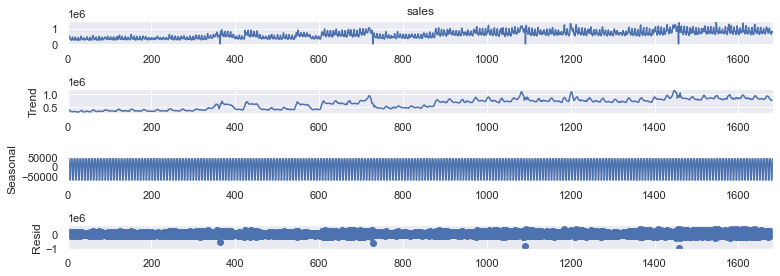

In [130]:
# Perform a STL decomposition on train_date['sales'] with a frequency of 7
res = sm.tsa.seasonal_decompose(train_date['sales'], period = 7).plot()
res = sm.tsa.seasonal_decompose(train_date['sales'], period = 7) 

In [131]:
# Get a SARIMA model for res 
mod = sm.tsa.statespace.SARIMAX(res.trend, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13411D+01    |proj g|=  5.13663D-02


 This problem is unconstrained.



At iterate    5    f=  1.13102D+01    |proj g|=  4.54804D-03

At iterate   10    f=  1.13086D+01    |proj g|=  3.13760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   4.587D-05   1.131D+01
  F =   11.308616536322102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                             trend   No. Observations:                 1684
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -19043.710
Date:                        

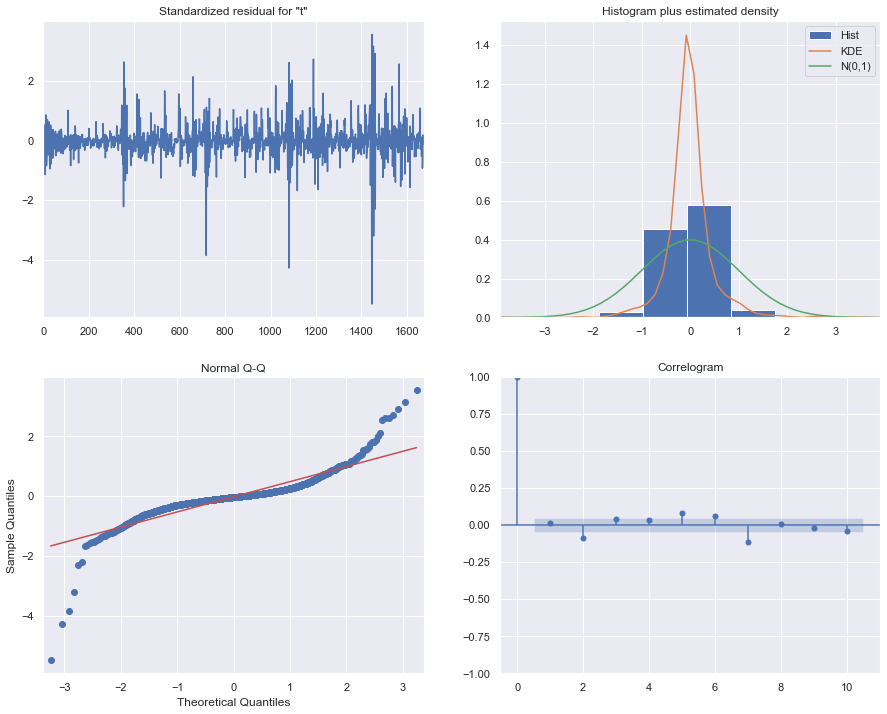

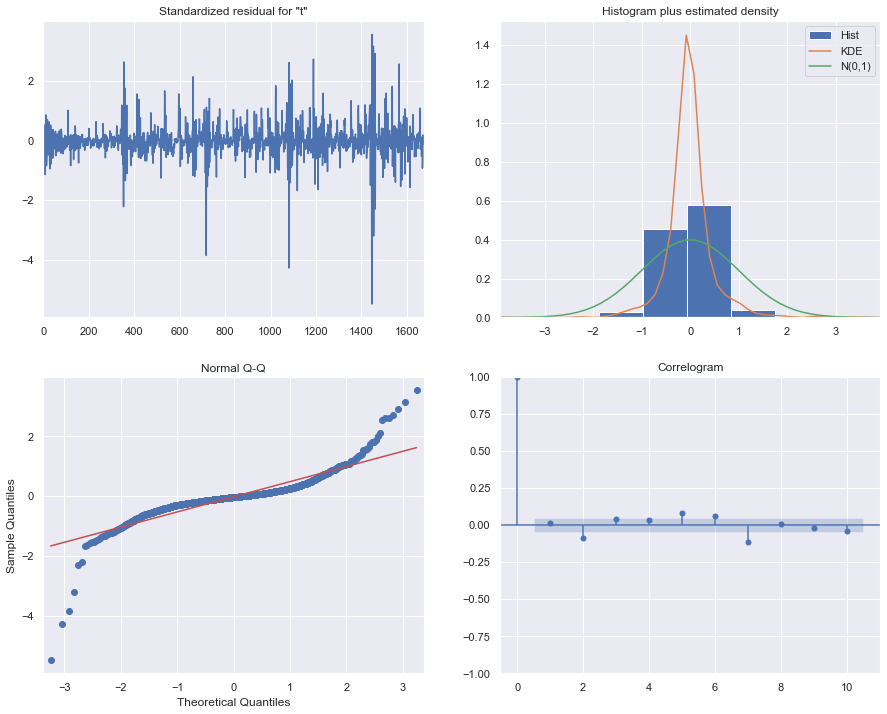

In [113]:
# Plot res
res.plot_diagnostics(figsize=(15,12))